# Student Performance Clustering
## Menggunakan K-Means









## Import Datasets (Collab)

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
satayjit_student_performance_bd_path = kagglehub.dataset_download('satayjit/student-performance-bd')

print('Data source import complete.')

100%|██████████| 224k/224k [00:00<00:00, 62.5MB/s]

Extracting files...
Data source import complete.


In [ ]:
import os

# Lokasi yang lebih umum untuk mencari dataset
base_path = '/root/.cache/kagglehub/datasets/satayjit/student-performance-bd'

# Mencari semua file di dalam folder dataset
for root, dirs, files in os.walk(base_path):
    for file in files:
        print(os.path.join(root, file))  # Menampilkan jalur lengkap setiap file

/root/.cache/kagglehub/datasets/satayjit/student-performance-bd/3.complete
/root/.cache/kagglehub/datasets/satayjit/student-performance-bd/versions/3/bd_students_per_v2.csv


## Import Libraries

In [ ]:
!pip install category_encoders
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
import category_encoders as ce
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
import warnings
warnings.filterwarnings('ignore')
# Load dataset
url = '/root/.cache/kagglehub/datasets/satayjit/student-performance-bd/versions/3/bd_students_per_v2.csv'
df = pd.read_csv(url)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 4.6 MB/s eta 0:00:00


# Exploratory Data Analysis (EDA)

In [ ]:
# Exploratory Data Analysis (EDA)
print("\n--- Exploratory Data Analysis (EDA) ---\n")

# 1. Informasi umum dataset
print("Informasi Dataset:")
df.info()
print("\nStatistik Deskriptif:")
print(df.describe(include='all'))

# 2. Memeriksa nilai kosong
missing_values = df.isnull().sum()
print("\nNilai Kosong per Kolom:")
print(missing_values[missing_values > 0])

# Menampilkan jumlah baris sebelum menghapus duplikat
print("Jumlah baris sebelum menghapus duplikat:", len(df))

# Menghapus duplikat berdasarkan semua kolom yang diinginkan
df_clean = df.drop_duplicates(subset=['full_name', 'gender', 'age', 'location',
                                    'mother_education', 'father_education',
                                    'mother_job', 'father_job', 'guardian',
                                    'family_size', 'school_type', 'studytime',
                                    'attendance', 'english', 'math', 'science',
                                    'social_science', 'art_culture', 'stu_group'],
                             keep='first')

# Menampilkan jumlah baris setelah menghapus duplikat
print("Jumlah baris setelah menghapus duplikat:", len(df_clean))

# Menampilkan jumlah baris yang dihapus
print("Jumlah baris yang dihapus:", len(df) - len(df_clean))

# Verifikasi duplikat yang tersisa
duplicates_check = df_clean.duplicated(subset=['full_name', 'gender', 'age', 'location',
                                             'mother_education', 'father_education',
                                             'mother_job', 'father_job', 'guardian',
                                             'family_size', 'school_type', 'studytime',
                                             'attendance', 'english', 'math', 'science',
                                             'social_science', 'art_culture', 'stu_group']).sum()

print("\nJumlah duplikat yang tersisa:", duplicates_check)

def remove_outliers_iqr(df, columns):
    # Menghapus outlier berdasarkan IQR untuk kolom numerikal tertentu di DataFrame.

    # Parameters:
    #     df (pd.DataFrame): DataFrame input.
    #     columns (list): Daftar nama kolom numerikal untuk dicek outlier-nya.

    # Returns:
    #     pd.DataFrame: DataFrame tanpa outlier pada kolom yang diberikan.

    df_cleaned = df.copy()
    for col in columns:
        # Hitung Q1 (kuartil ke-25) dan Q3 (kuartil ke-75)
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)

        # Hitung IQR
        IQR = Q3 - Q1

        # Tentukan batas bawah dan atas
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Hapus baris yang di luar batas
        df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound) & (df_cleaned[col] <= upper_bound)]

    return df_cleaned



--- Exploratory Data Analysis (EDA) ---

Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8612 entries, 0 to 8611
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   id                           8612 non-null   int64 
 1   full_name                    8612 non-null   object
 2   age                          8612 non-null   int64 
 3   gender                       8612 non-null   object
 4   location                     8611 non-null   object
 5   family_size                  8612 non-null   int64 
 6   mother_education             8602 non-null   object
 7   father_education             8608 non-null   object
 8   mother_job                   8612 non-null   object
 9   father_job                   8612 non-null   object
 10  guardian                     8612 non-null   object
 11  parental_involvement         8612 non-null   object
 12  internet_access              

### Drop unrelevant column & Distribusi Feature

In [ ]:
# Definisikan fungsi frequency encoding
def frequency_encoding(df, column):
    frequency = df[column].value_counts(normalize=True)
    return df[column].map(frequency)

# Tangani missing values terlebih dahulu
df['mother_education'] = df['mother_education'].fillna('Non_Educated')
df['father_education'] = df['father_education'].fillna('Non_Educated')
df['location'] = df['location'].fillna(df['location'].mode()[0])


Distribusi Fitur Numerik:


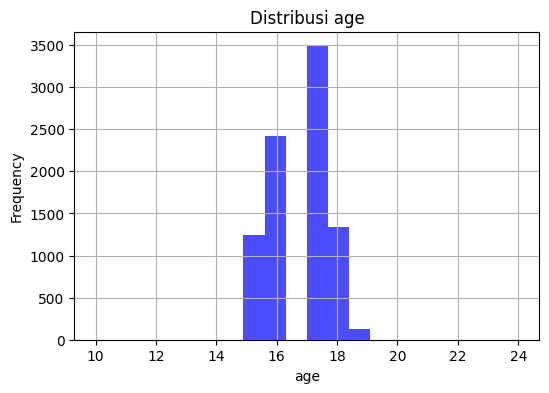

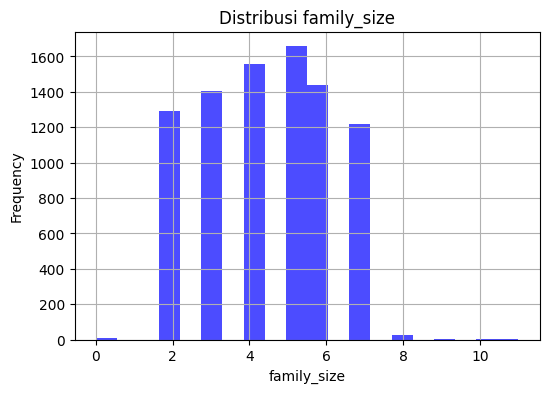

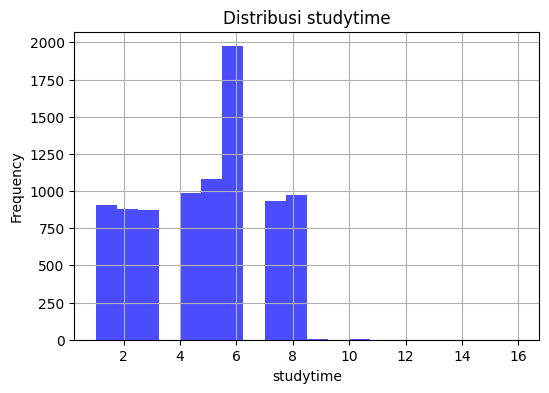

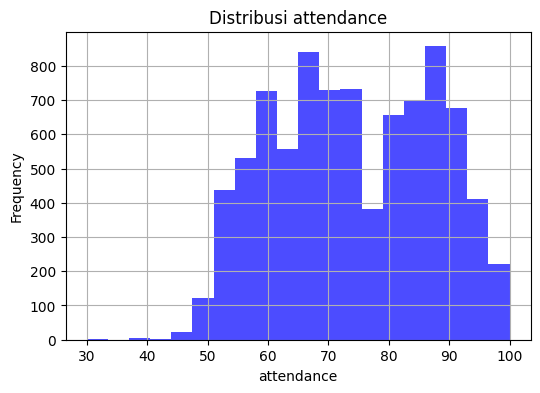

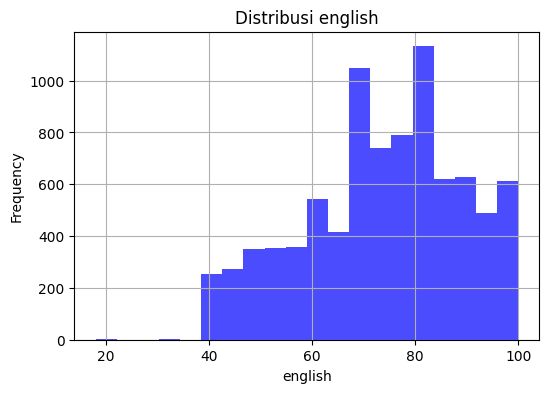

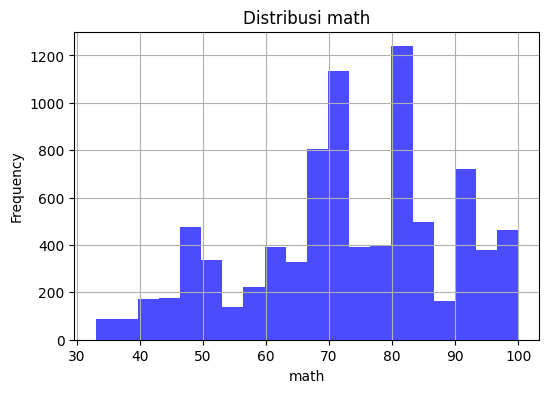

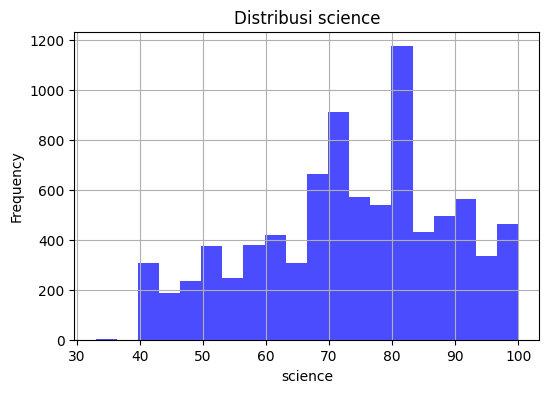

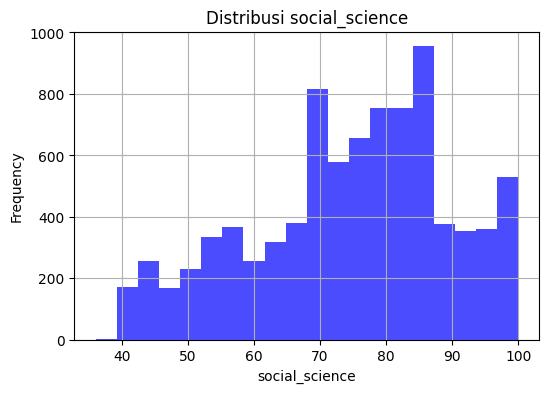

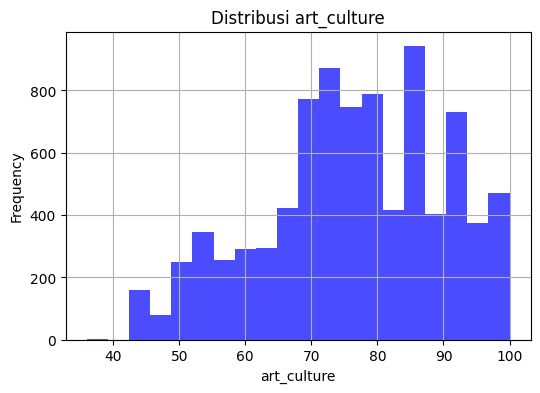


Distribusi Fitur Kategorikal:


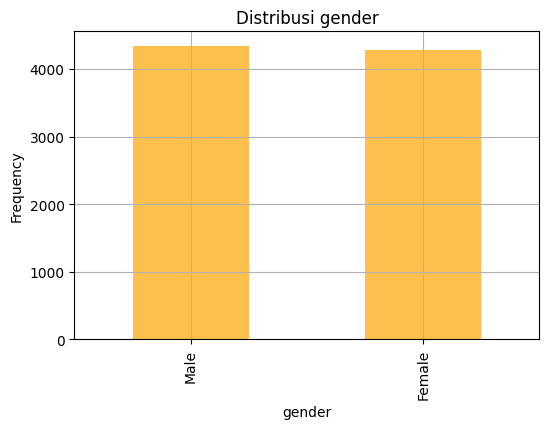

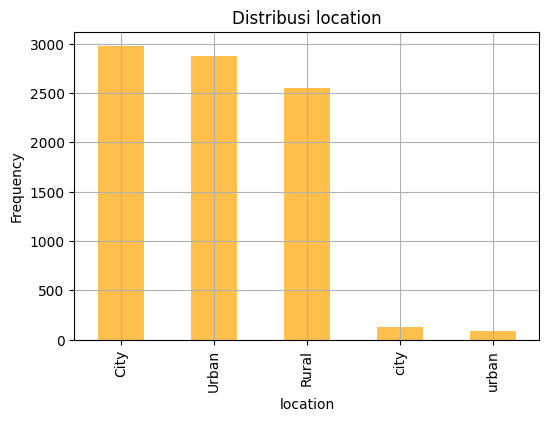

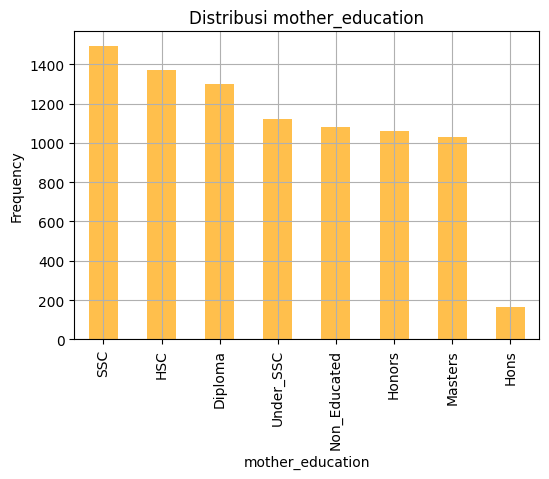

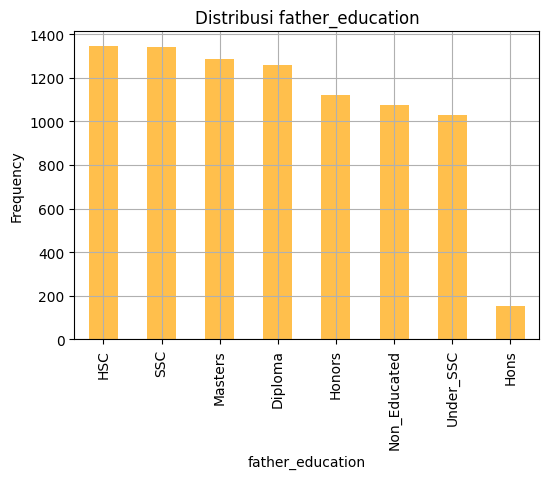

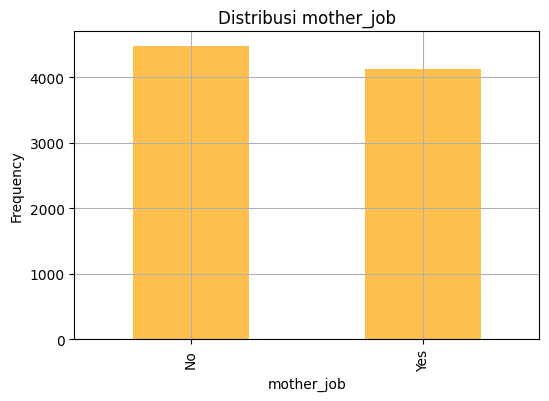

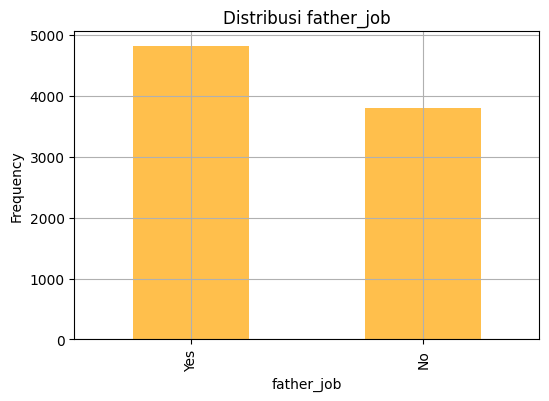

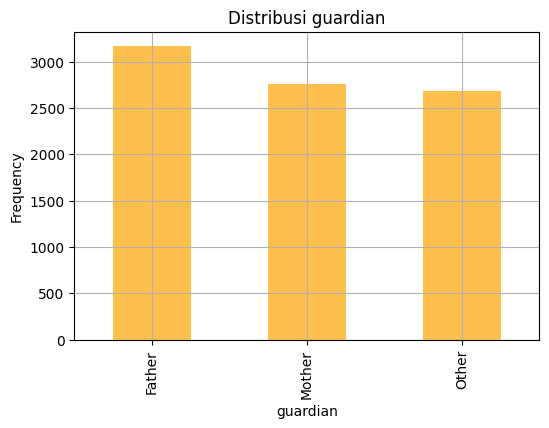

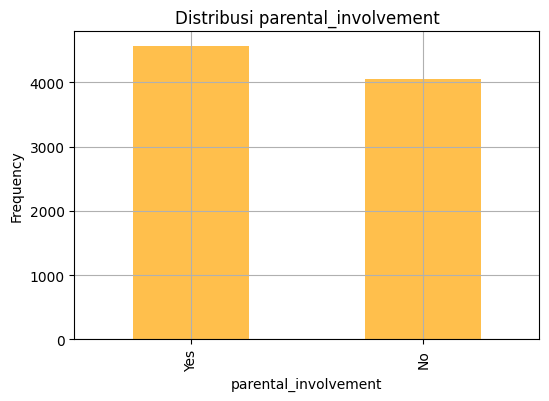

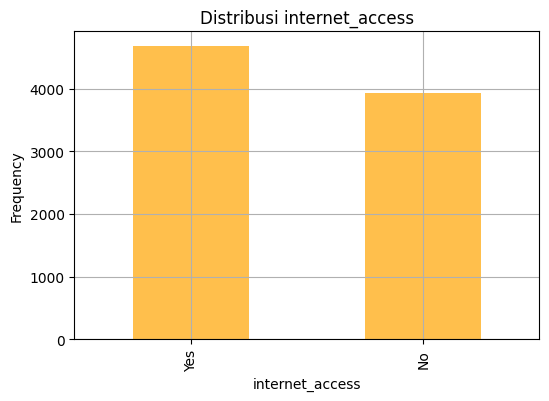

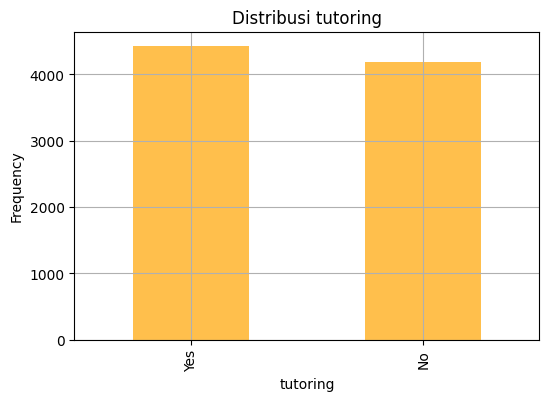

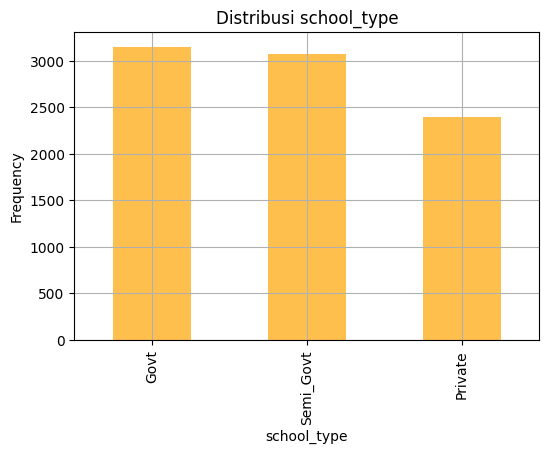

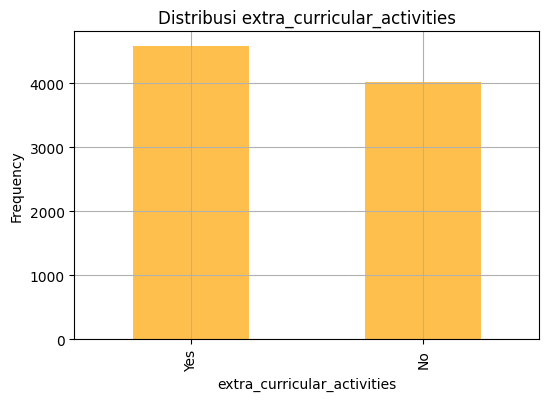

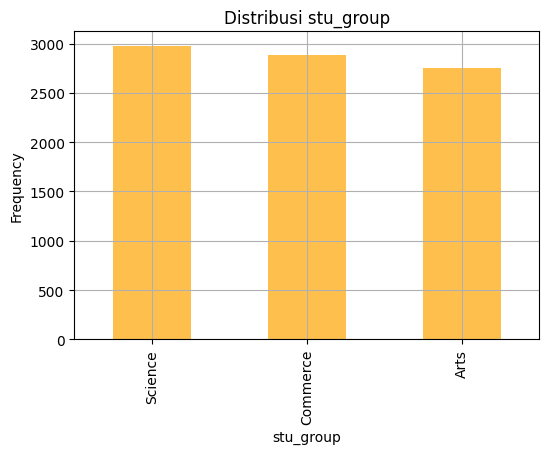

In [ ]:
# 3. Distribusi fitur numerik

# Simpan kolom id dan full_name untuk referensi di akhir
id_fullname_df = df[['id', 'full_name']]

# Drop kolom yang tidak relevan (id, full_name)
df = df.drop(columns=['id', 'full_name'])

numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
print("\nDistribusi Fitur Numerik:")
for col in numeric_columns:
    plt.figure(figsize=(6, 4))
    plt.hist(df[col], bins=20, color='blue', alpha=0.7)
    plt.title(f'Distribusi {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# 4. Distribusi fitur kategorikal
categorical_columns = df.select_dtypes(include=['object']).columns
print("\nDistribusi Fitur Kategorikal:")
for col in categorical_columns:
    plt.figure(figsize=(6, 4))
    df[col].value_counts().plot(kind='bar', color='orange', alpha=0.7)
    plt.title(f'Distribusi {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

### Handle null values

In [ ]:
# 3. Memeriksa nilai kosong setelah diisi
missing_values = df.isnull().sum()
print("\nNilai Kosong per Kolom setelah diisi:")
print(missing_values[missing_values > 0])

# Pilih kolom kategorikal dan numerikal
categorical_columns = df.select_dtypes(include=['object']).columns
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

for col in categorical_columns:
    print(f"Kategori unik di {col}: {df[col].unique()}")


Nilai Kosong per Kolom setelah diisi:
Series([], dtype: int64)
Kategori unik di gender: ['Male' 'Female']
Kategori unik di location: ['Urban' 'Rural' 'City' 'urban' 'city']
Kategori unik di mother_education: ['SSC' 'Honors' 'HSC' 'Diploma' 'Masters' 'Under_SSC' 'Hons'
 'Non_Educated']
Kategori unik di father_education: ['HSC' 'SSC' 'Masters' 'Diploma' 'Honors' 'Hons' 'Under_SSC'
 'Non_Educated']
Kategori unik di mother_job: ['No' 'Yes']
Kategori unik di father_job: ['No' 'Yes']
Kategori unik di guardian: ['Father' 'Mother' 'Other']
Kategori unik di parental_involvement: ['Yes' 'No']
Kategori unik di internet_access: ['Yes' 'No']
Kategori unik di tutoring: ['Yes' 'No']
Kategori unik di school_type: ['Private' 'Semi_Govt' 'Govt']
Kategori unik di extra_curricular_activities: ['Yes' 'No']
Kategori unik di stu_group: ['Science' 'Commerce' 'Arts']


### Convert categorical feature (Ordinal & Binary)

In [ ]:
# 1. Ordinal Encoding untuk mother_education dan father_education
education_order = ['Non_Educated', 'Under_SSC', 'SSC', 'HSC', 'Diploma', 'Hons', 'Honors', 'Masters']
ordinal_columns = ['mother_education', 'father_education']
ordinal_encoder = OrdinalEncoder(categories=[education_order] * len(ordinal_columns))
df[ordinal_columns] = ordinal_encoder.fit_transform(df[ordinal_columns])

# 2. Binary Encoding untuk kolom sederhana
binary_columns = [
    'gender','school_type', 'stu_group', 'guardian', 'parental_involvement',
    'internet_access', 'tutoring', 'extra_curricular_activities'
]
binary_encoder = ce.BinaryEncoder(cols=binary_columns)
binary_encoded = binary_encoder.fit_transform(df[binary_columns])
df = pd.concat([df, binary_encoded], axis=1)

# 3. Frequency Encoding untuk kolom dengan banyak kategori
frequency_columns = ['location', 'mother_job', 'father_job']
def frequency_encoding(data, col):
    freq_map = data[col].value_counts() / len(data)
    return data[col].map(freq_map)

for col in frequency_columns:
    df[col + '_freq'] = frequency_encoding(df, col)

# Hapus kolom kategorikal asli setelah encoding
categorical_columns = ordinal_columns + binary_columns + frequency_columns
df = df.drop(columns=categorical_columns)

# Gabungkan data numerik dan kategorikal
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
correlation_data = df[numeric_columns]

### Correlation Matrix & Pemilihan Feature


=== DEBUGGING INFO ===

Semua kolom dan rata-rata korelasi dengan mata pelajaran:
                       Column  Mean_Correlation
                      english          0.828727
                      science          0.827954
                         math          0.824814
               social_science          0.814960
                  art_culture          0.789628
                    studytime          0.759285
                  stu_group_0          0.717353
                   attendance          0.441227
                location_freq          0.132666
                school_type_0          0.117837
                school_type_1          0.116310
                  stu_group_1          0.033296
                   tutoring_1          0.026569
                   tutoring_0          0.026569
              mother_job_freq          0.017729
            internet_access_1          0.016204
            internet_access_0          0.016204
                          age          0.014366
     

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]),
 [Text(0, 0.5, 'english'),
  Text(0, 1.5, 'science'),
  Text(0, 2.5, 'math'),
  Text(0, 3.5, 'social_science'),
  Text(0, 4.5, 'art_culture'),
  Text(0, 5.5, 'studytime')])

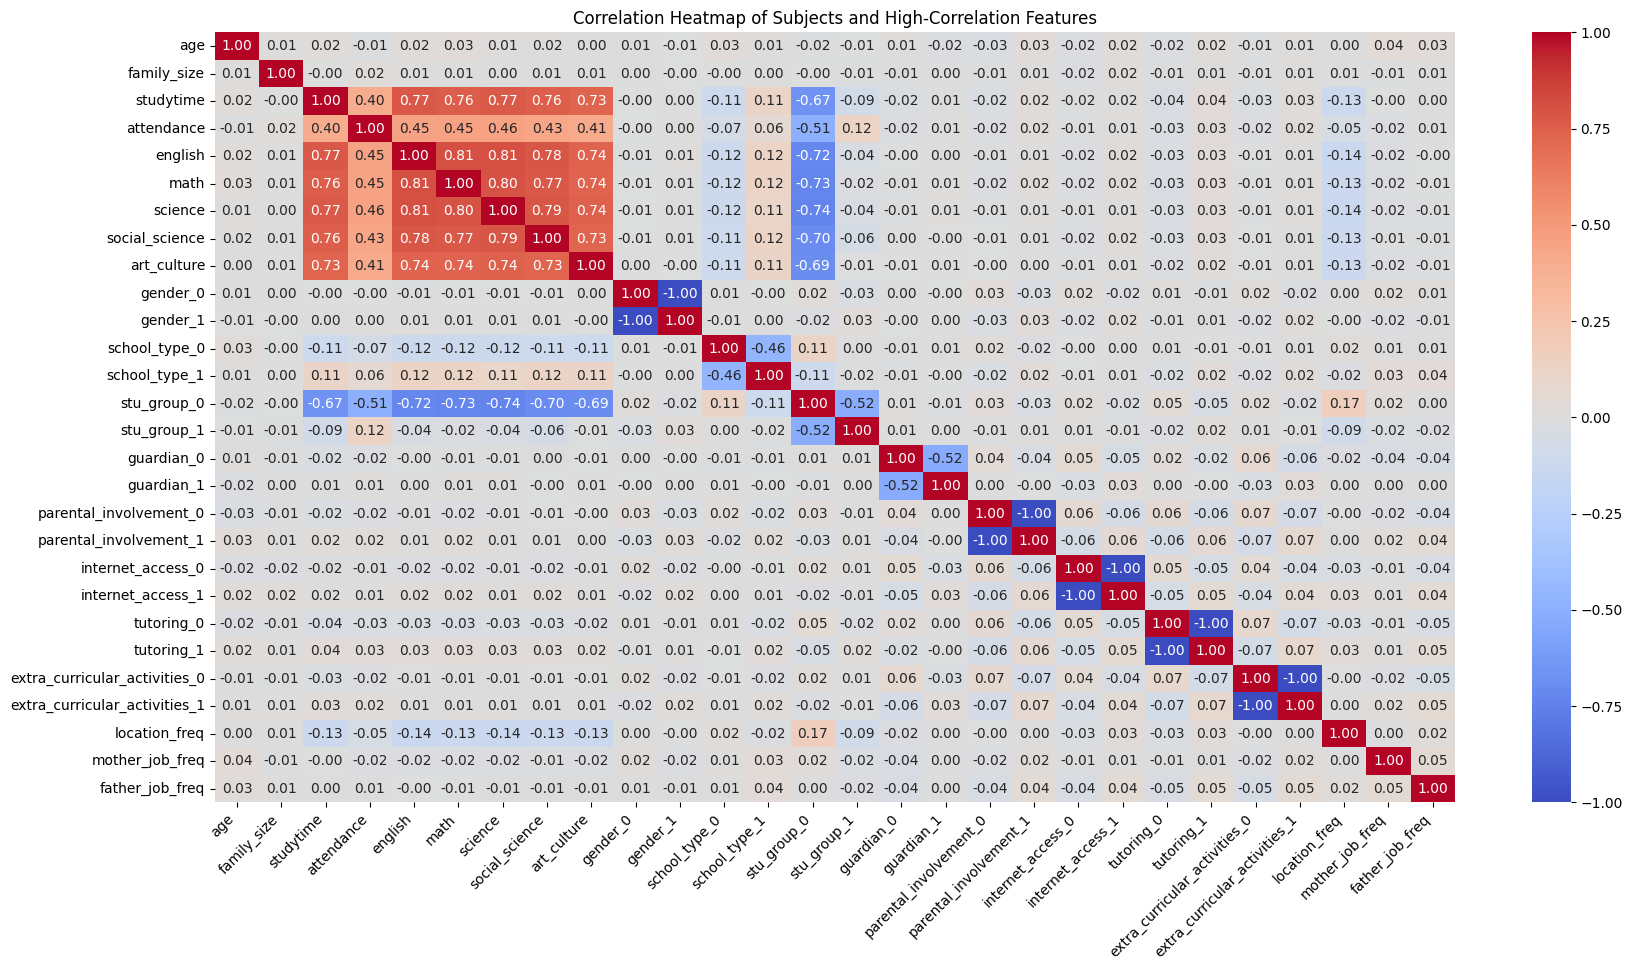

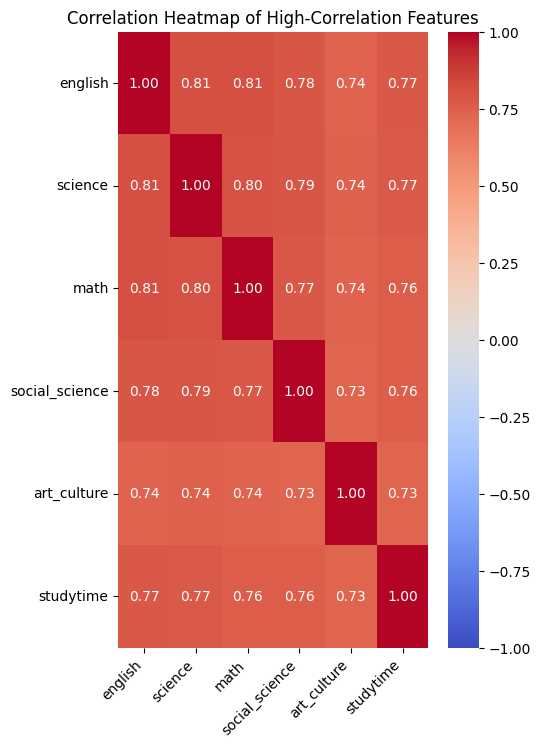

In [ ]:
# Definisikan kolom mata pelajaran yang menjadi target
subject_columns = ['english', 'math', 'science', 'social_science', 'art_culture']

# Hitung korelasi seluruh kolom dengan mata pelajaran
full_correlation = correlation_data.corr()

# Buat heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(full_correlation,
            annot=True,
            cmap='coolwarm',
            vmin=-1,
            vmax=1,
            center=0,
            fmt='.2f')

plt.title('Correlation Heatmap of Subjects and High-Correlation Features')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Hitung rata-rata korelasi absolut dengan mata pelajaran untuk setiap kolom
mean_correlations = {}
for column in correlation_data.columns:
    correlations = [abs(full_correlation.loc[column, subject]) for subject in subject_columns]
    mean_correlations[column] = np.mean(correlations)

# Buat DataFrame untuk debugging yang lebih mudah dibaca
debug_df = pd.DataFrame({
    'Column': list(mean_correlations.keys()),
    'Mean_Correlation': list(mean_correlations.values())
})

# Urutkan berdasarkan rata-rata korelasi dari tertinggi ke terendah
debug_df = debug_df.sort_values('Mean_Correlation', ascending=False)

# Tampilkan semua kolom dan rata-rata korelasinya
print("\n=== DEBUGGING INFO ===")
print("\nSemua kolom dan rata-rata korelasi dengan mata pelajaran:")
print("=" * 60)
print(debug_df.to_string(index=False))
print("\n=== SUMMARY ===")
print(f"Total kolom dalam dataset: {len(debug_df)}")
print(f"Kolom dengan korelasi > 0.75: {len(debug_df[debug_df['Mean_Correlation'] > 0.75])}")
print("\n=== DETAILED CORRELATIONS FOR HIGH CORRELATION COLUMNS ===")

# Filter dan tampilkan detail untuk kolom dengan korelasi tinggi
high_corr_columns = debug_df[debug_df['Mean_Correlation'] > 0.75]['Column'].tolist()

# Tampilkan detail korelasi untuk kolom-kolom dengan korelasi tinggi
for col in high_corr_columns:
    print(f"\n{col}:")
    print(f"Rata-rata korelasi absolut: {mean_correlations[col]:.3f}")
    print("Korelasi dengan setiap mata pelajaran:")
    for subject in subject_columns:
        corr = full_correlation.loc[col, subject]
        print(f"- {subject}: {corr:.3f}")

# Buat heatmap untuk kolom yang terfilter
plt.figure(figsize=(5, 8))
filtered_correlation = correlation_data[high_corr_columns].corr()

sns.heatmap(filtered_correlation,
            annot=True,
            cmap='coolwarm',
            vmin=-1,
            vmax=1,
            center=0,
            fmt='.2f')

plt.title('Correlation Heatmap of High-Correlation Features')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

In [ ]:
print(df.describe())
print("\n=========================================================================\n")
print(high_corr_columns)
print("\n=========================================================================\n")
print(df[high_corr_columns])

               age  family_size    studytime   attendance      english  \
count  8612.000000  8612.000000  8612.000000  8612.000000  8612.000000   
mean     16.614375     4.502206     4.746168    74.027055    73.610427   
std       0.969057     1.656726     2.185645    13.290046    15.343903   
min      10.000000     0.000000     1.000000    30.000000    18.000000   
25%      16.000000     3.000000     3.000000    63.000000    64.000000   
50%      17.000000     5.000000     5.000000    73.000000    75.000000   
75%      17.000000     6.000000     6.000000    86.000000    85.000000   
max      24.000000    11.000000    16.000000   100.000000   100.000000   

              math      science  social_science  art_culture     gender_0  \
count  8612.000000  8612.000000     8612.000000  8612.000000  8612.000000   
mean     72.938110    73.524036       74.465513    76.236066     0.496400   
std      15.816147    15.115104       14.945846    13.619125     0.500016   
min      33.000000    33.

# Normalisasi Data & Mulai Clustering tanpa PCA

Processing Clusters...

Clusters | SSE               | Mean Silhouette Score
--------------------------------------------------
   2     | 8983.8013        | 0.5171
   3     | 5465.4180        | 0.4506
   4     | 5053.3459        | 0.3639
   5     | 4796.6315        | 0.2670
   6     | 4566.6194        | 0.2402
   7     | 4374.0491        | 0.1783
   8     | 4150.4885        | 0.1549
   9     | 4006.9271        | 0.1651

Final Silhouette Score on Full Dataset: 0.4505335023570677

Dataframe dengan cluster:
        id         full_name  cluster
0        2        Avi Biswas        1
1        3   Taslima Sultana        2
2        4  Md Adilur Rahman        2
3        5       Saleh Ahmed        1
4        6         Din Islam        2
...    ...               ...      ...
8607  8609      Elina Khanam        1
8608  8610       Sadiq Ghosh        1
8609  8611        Arman Amin        0
8610  8612     Tawhidul Saif        0
8611  8613        Naimul Sen        1

[8612 rows x 3 columns]

Ringkas

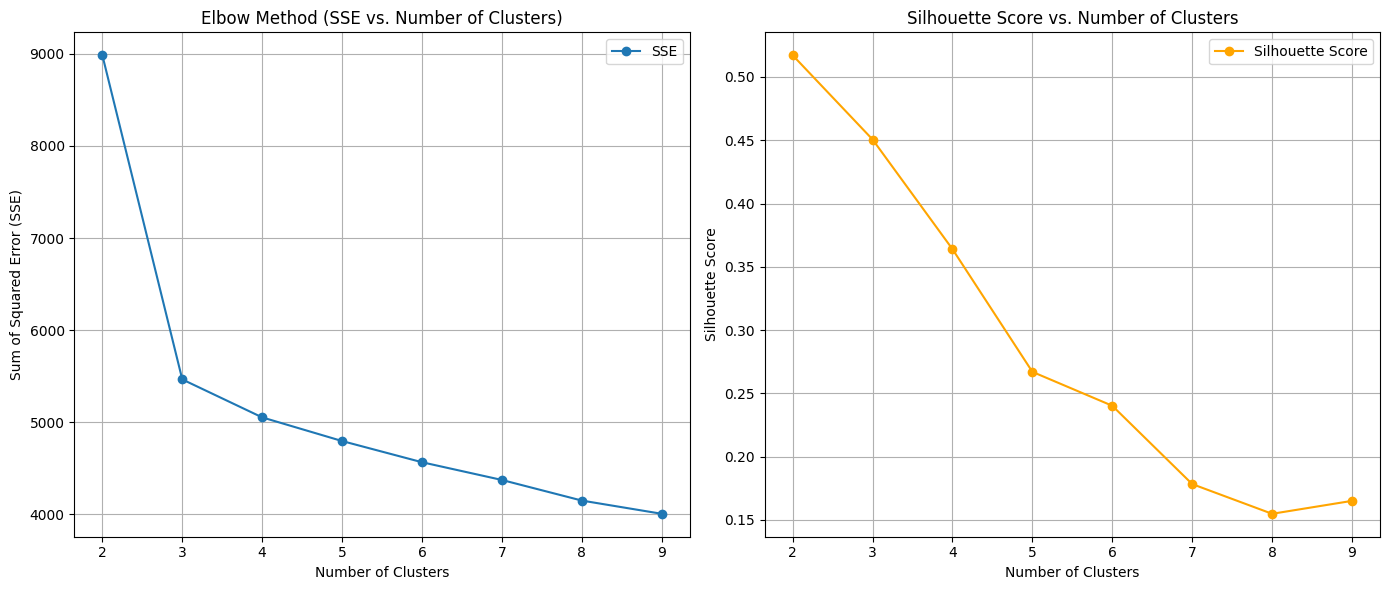

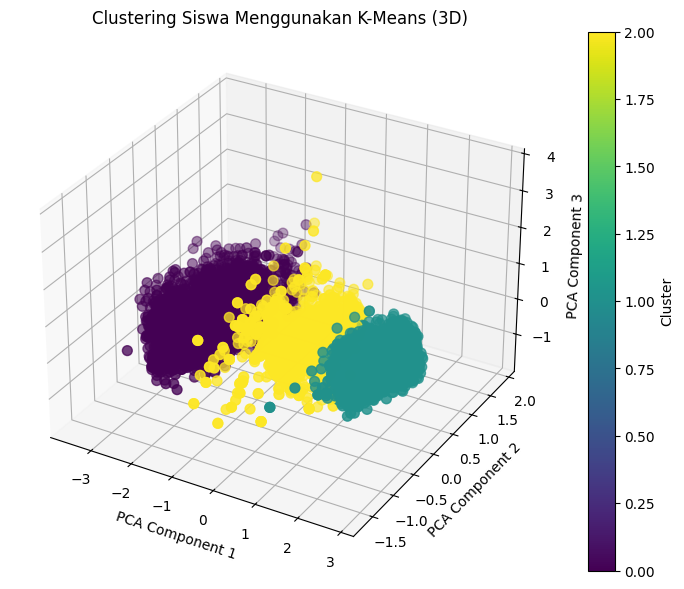

In [ ]:
# Normalisasi data
scaler = RobustScaler()
features = df[high_corr_columns].values
features_scaled = scaler.fit_transform(features)

# Tentukan range jumlah cluster
cluster_range = range(2, 10)
cv_results = {}
elbow_sse = []

print("Processing Clusters...\n")
print("Clusters | SSE               | Mean Silhouette Score")
print("-" * 50)

# Loop untuk mengevaluasi jumlah cluster
for n_clusters in cluster_range:
    cv_silhouette_scores = []
    sse = 0

    # Gunakan features untuk splitting
    for train_index, test_index in KFold(n_splits=5, shuffle=True, random_state=42).split(features_scaled):
        X_train, X_test = features_scaled[train_index], features_scaled[test_index]

        # Melatih model K-Means
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(X_train)

        # Prediksi dan evaluasi pada test split
        test_labels = kmeans.predict(X_test)
        score = silhouette_score(X_test, test_labels)
        cv_silhouette_scores.append(score)

        # Hitung SSE (Sum of Squared Errors)
        sse += kmeans.inertia_

    # Rata-rata SSE dan Silhouette Score
    mean_silhouette_score = np.mean(cv_silhouette_scores)
    mean_sse = sse / 5  # Rata-rata SSE dari 5 fold

    # Simpan hasil untuk jumlah cluster ini
    cv_results[n_clusters] = mean_silhouette_score
    elbow_sse.append(mean_sse)

    # Tampilkan hasil debugging
    print(f"{n_clusters:^8} | {mean_sse:<16.4f} | {mean_silhouette_score:<.4f}")

# Tentukan jumlah cluster optimal berdasarkan hasil
optimal_clusters = 3
final_kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
final_labels = final_kmeans.fit_predict(features_scaled)

# Evaluasi pada seluruh dataset
final_silhouette_score = silhouette_score(features_scaled, final_labels)
print(f"\nFinal Silhouette Score on Full Dataset: {final_silhouette_score}")

# Tambahkan hasil clustering ke DataFrame asli
id_fullname_df['cluster'] = final_labels

# Tambahkan hasil cluster ke dataframe utama
df['optimal_cluster'] = final_labels

# Hitung rata-rata fitur dalam setiap cluster
cluster_summary = df.groupby('optimal_cluster')[['english', 'science', 'math', 'social_science', 'art_culture', 'studytime']].mean()
print("\nDataframe dengan cluster:")
print(id_fullname_df)
print("\nRingkasan cluster:")
print(cluster_summary)

# Plot grafik Elbow Method dan Silhouette Score
plt.figure(figsize=(14, 6))

# Grafik Elbow Method
plt.subplot(1, 2, 1)
plt.plot(cluster_range, elbow_sse, marker='o', label='SSE')
plt.title('Elbow Method (SSE vs. Number of Clusters)')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Error (SSE)')
plt.xticks(cluster_range)
plt.grid(True)
plt.legend()

# Grafik Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(cluster_range, [cv_results[k] for k in cluster_range], marker='o', color='orange', label='Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(cluster_range)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Visualisasi hasil clustering dalam 3D
pca = PCA(n_components=3)
features_pca = pca.fit_transform(features_scaled)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2],
                    c=df['optimal_cluster'], cmap='viridis', s=50)
ax.set_title('Clustering Siswa Menggunakan K-Means (3D)')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
plt.colorbar(scatter, ax=ax, label='Cluster')
plt.show()

## Melakukan PCA dengan mempertahankan 95% Varians

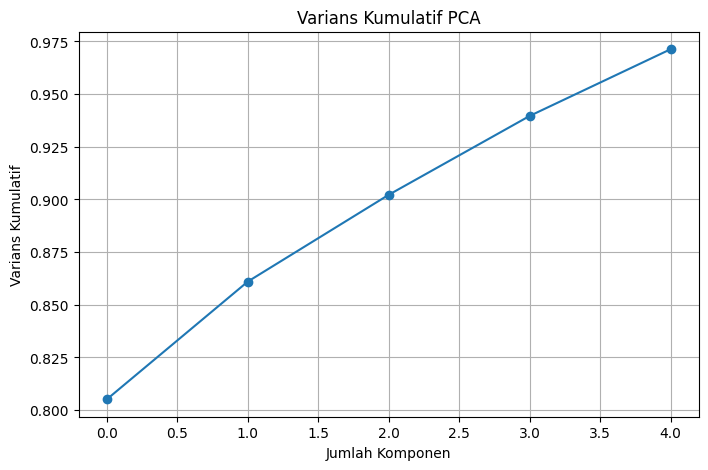

Jumlah komponen yang dipilih oleh PCA: 5
[[ 2.63110994  0.15420781 -0.03147443 -0.15136471 -0.09891867]
 [-0.72924436  0.55536775 -0.05084705  0.11439659 -0.67148748]
 [-0.15340581 -0.07164507  0.0878424   0.23590261 -0.8488832 ]
 ...
 [-2.53984396  0.65470822 -0.47292741 -0.26373825 -0.4928391 ]
 [-1.49100321  0.15003487 -0.66598463  0.35289003 -0.19859567]
 [ 2.58984035  0.21635744  0.11632535  0.16071126 -0.37084722]]


In [ ]:
features = df[high_corr_columns]
# PCA untuk mempertahankan 95% varians
pca = PCA(n_components=0.95)

# Scale fitur sebelum PCA
features_scaled_pre_pca = scaler.fit_transform(features)
features_scaled = pca.fit_transform(features_scaled_pre_pca)

# Visualisasi varians kumulatif
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Jumlah Komponen')
plt.ylabel('Varians Kumulatif')
plt.title('Varians Kumulatif PCA')
plt.grid(True)
plt.show()

print(f"Jumlah komponen yang dipilih oleh PCA: {pca.n_components_}")

print(features_scaled)

## Clustering dengan PCA 95% Varians

Processing Clusters...

Clusters | SSE               | Mean Silhouette Score
--------------------------------------------------
   2     | 8329.9606        | 0.5325
   3     | 4811.8371        | 0.4780
   4     | 4419.0369        | 0.3839
   5     | 4164.4003        | 0.3334
   6     | 3889.0662        | 0.2437
   7     | 3691.2000        | 0.2224
   8     | 3512.6522        | 0.1981
   9     | 3366.5319        | 0.1805
Final Silhouette Score on Test Set: 0.4779747254447087

Dataframe dengan cluster:
        id         full_name  cluster
0        2        Avi Biswas        1
1        3   Taslima Sultana        2
2        4  Md Adilur Rahman        2
3        5       Saleh Ahmed        1
4        6         Din Islam        2
...    ...               ...      ...
8607  8609      Elina Khanam        1
8608  8610       Sadiq Ghosh        1
8609  8611        Arman Amin        0
8610  8612     Tawhidul Saif        0
8611  8613        Naimul Sen        1

[8612 rows x 3 columns]

Ringkasan cl

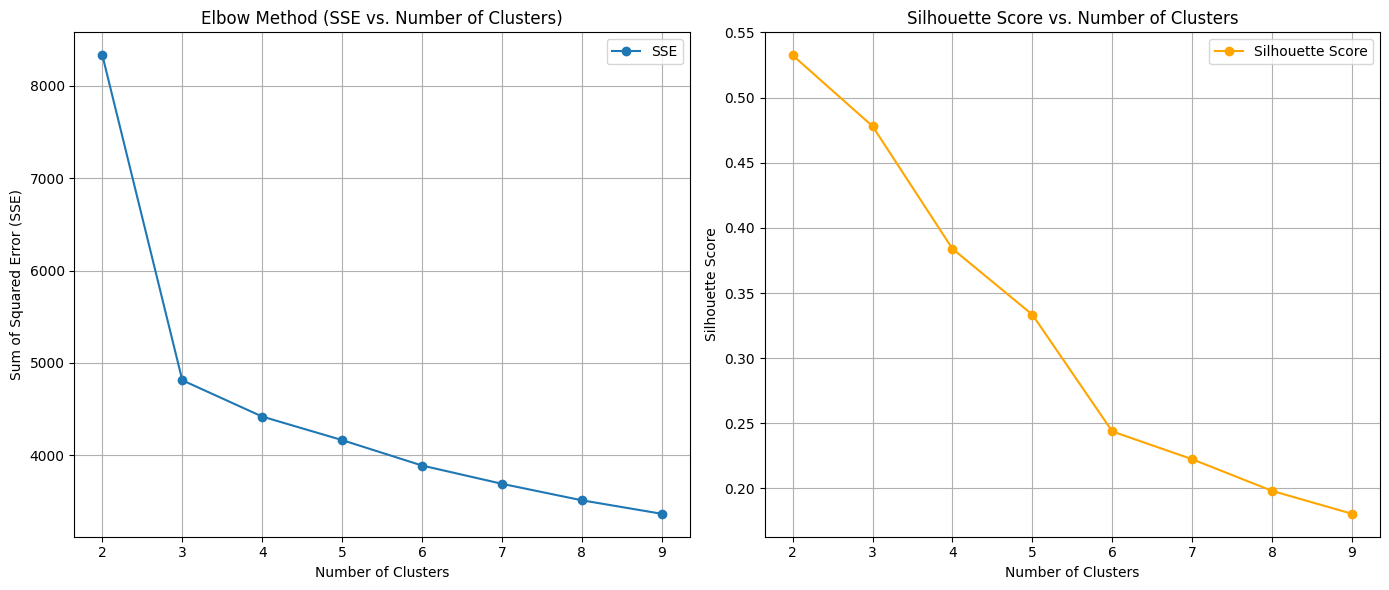

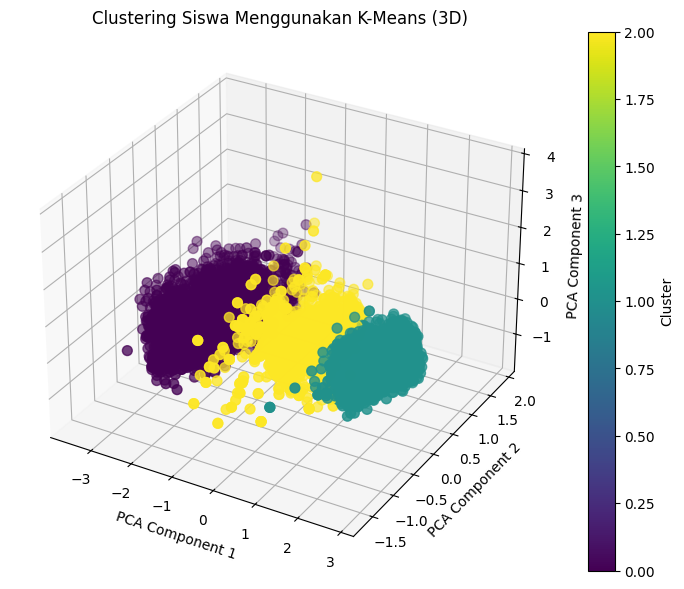

In [ ]:
# Tentukan range jumlah cluster
cluster_range = range(2, 10)  # Misalnya, coba 2 hingga 9 cluster
cv_results = {}
elbow_sse = []

print("Processing Clusters...\n")
print("Clusters | SSE               | Mean Silhouette Score")
print("-" * 50)

# Loop untuk mengevaluasi jumlah cluster
for n_clusters in cluster_range:
    cv_silhouette_scores = []
    sse = 0

    for train_index, test_index in KFold(n_splits=5, shuffle=True, random_state=42).split(features_scaled):
        X_train, X_test = features_scaled[train_index], features_scaled[test_index]

        # Melatih model K-Means
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(X_train)

        # Prediksi dan evaluasi pada test split
        test_labels = kmeans.predict(X_test)
        score = silhouette_score(X_test, test_labels)
        cv_silhouette_scores.append(score)

        # Hitung SSE (Sum of Squared Errors)
        sse += kmeans.inertia_

    # Rata-rata SSE dan Silhouette Score
    mean_silhouette_score = np.mean(cv_silhouette_scores)
    mean_sse = sse / 5  # Rata-rata SSE dari 5 fold

    # Simpan hasil untuk jumlah cluster ini
    cv_results[n_clusters] = mean_silhouette_score
    elbow_sse.append(mean_sse)

    # Tampilkan hasil debugging
    print(f"{n_clusters:^8} | {mean_sse:<16.4f} | {mean_silhouette_score:<.4f}")

# Tentukan jumlah cluster optimal berdasarkan hasil (contoh: 3 cluster)
optimal_clusters = 3
final_kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
final_labels = final_kmeans.fit_predict(features_scaled)

# Evaluasi pada seluruh dataset
final_silhouette_score = silhouette_score(features_scaled, final_labels)
print(f"Final Silhouette Score on Test Set: {final_silhouette_score}")

# Tambahkan hasil clustering ke DataFrame asli
id_fullname_df['cluster'] = final_labels

# Tambahkan hasil cluster ke dataframe utama
df['optimal_cluster'] = final_labels

# Hitung rata-rata fitur dalam setiap cluster
cluster_summary = df.groupby('optimal_cluster')[['english', 'science', 'math', 'social_science', 'art_culture', 'studytime']].mean()
print("\nDataframe dengan cluster:")
print(id_fullname_df)
print("\nRingkasan cluster:")
print(cluster_summary)

# Plot grafik Elbow Method dan Silhouette Score
plt.figure(figsize=(14, 6))

# Grafik Elbow Method
plt.subplot(1, 2, 1)
plt.plot(cluster_range, elbow_sse, marker='o', label='SSE')
plt.title('Elbow Method (SSE vs. Number of Clusters)')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Error (SSE)')
plt.xticks(cluster_range)
plt.grid(True)
plt.legend()

# Grafik Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(cluster_range, [cv_results[k] for k in cluster_range], marker='o', color='orange', label='Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(cluster_range)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Visualisasi hasil clustering dalam 3D
pca = PCA(n_components=3)
features_pca = pca.fit_transform(features_scaled)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2],
                      c=df['optimal_cluster'], cmap='viridis', s=50)
ax.set_title('Clustering Siswa Menggunakan K-Means (3D)')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
plt.colorbar(scatter, ax=ax, label='Cluster')
plt.show()

## Melakukan PCA dengan mempertahankan 90% Varians

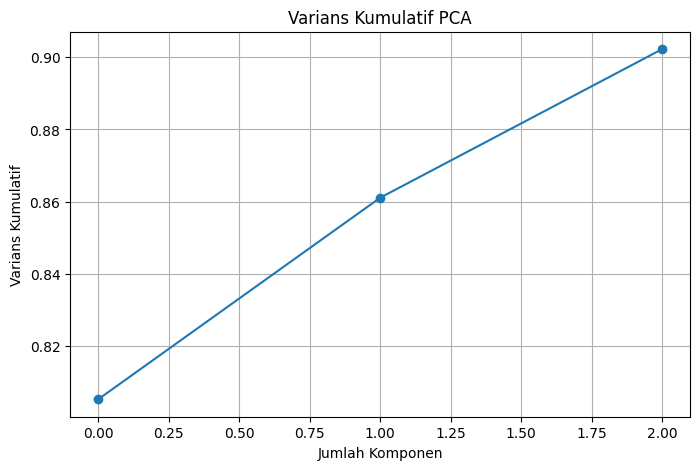

Jumlah komponen yang dipilih oleh PCA: 3
[[ 2.63110994  0.15420781 -0.03147443]
 [-0.72924436  0.55536775 -0.05084705]
 [-0.15340581 -0.07164507  0.0878424 ]
 ...
 [-2.53984396  0.65470822 -0.47292741]
 [-1.49100321  0.15003487 -0.66598463]
 [ 2.58984035  0.21635744  0.11632535]]


In [ ]:
features = df[high_corr_columns]
# PCA untuk mempertahankan 90% varians
pca = PCA(n_components=0.9)

# Scale fitur sebelum PCA
features_scaled_pre_pca = scaler.fit_transform(features)
features_scaled = pca.fit_transform(features_scaled_pre_pca)

# Visualisasi varians kumulatif
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Jumlah Komponen')
plt.ylabel('Varians Kumulatif')
plt.title('Varians Kumulatif PCA')
plt.grid(True)
plt.show()

print(f"Jumlah komponen yang dipilih oleh PCA: {pca.n_components_}")

print(features_scaled)

## Clustering dengan PCA 90% Varians

Processing Clusters...

Clusters | SSE               | Mean Silhouette Score
--------------------------------------------------
   2     | 6755.0296        | 0.5767
   3     | 3236.9389        | 0.5605
   4     | 2898.7179        | 0.4372
   5     | 2637.7212        | 0.3565
   6     | 2348.4078        | 0.2828
   7     | 2170.8062        | 0.2511
   8     | 1998.0739        | 0.2540
   9     | 1862.6944        | 0.2526
Final Silhouette Score on Test Set: 0.5604319101207803

Dataframe dengan cluster:
        id         full_name  cluster
0        2        Avi Biswas        2
1        3   Taslima Sultana        1
2        4  Md Adilur Rahman        1
3        5       Saleh Ahmed        2
4        6         Din Islam        1
...    ...               ...      ...
8607  8609      Elina Khanam        2
8608  8610       Sadiq Ghosh        2
8609  8611        Arman Amin        0
8610  8612     Tawhidul Saif        0
8611  8613        Naimul Sen        2

[8612 rows x 3 columns]

Ringkasan cl

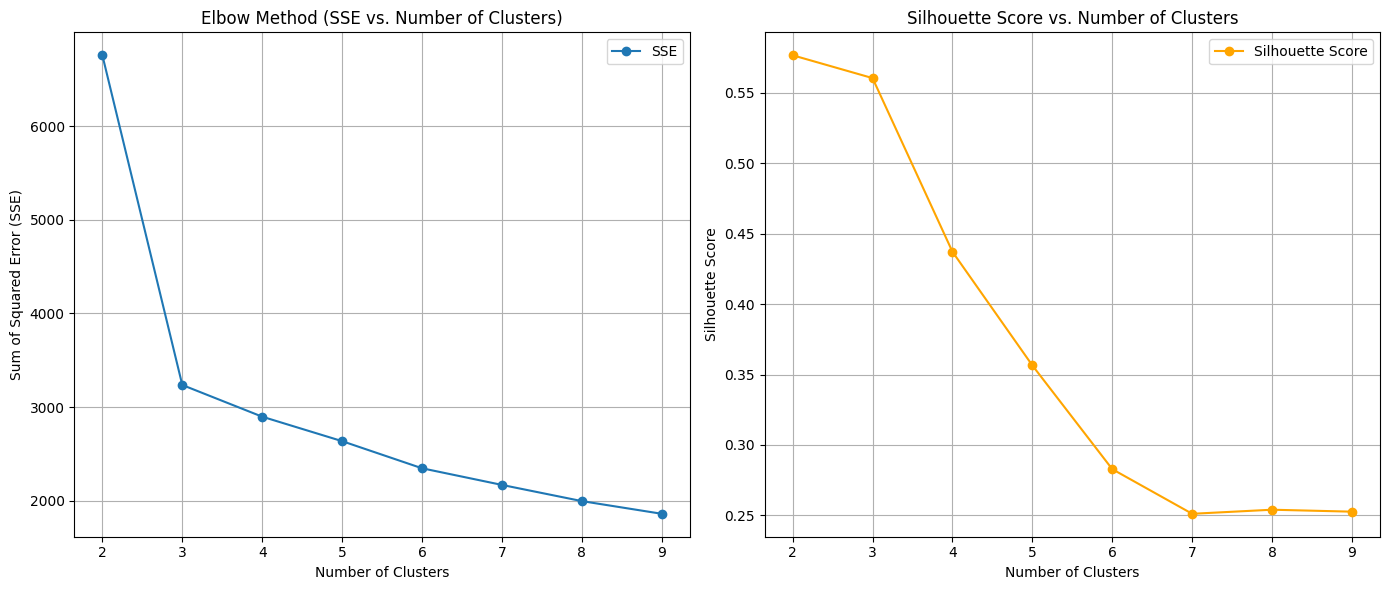

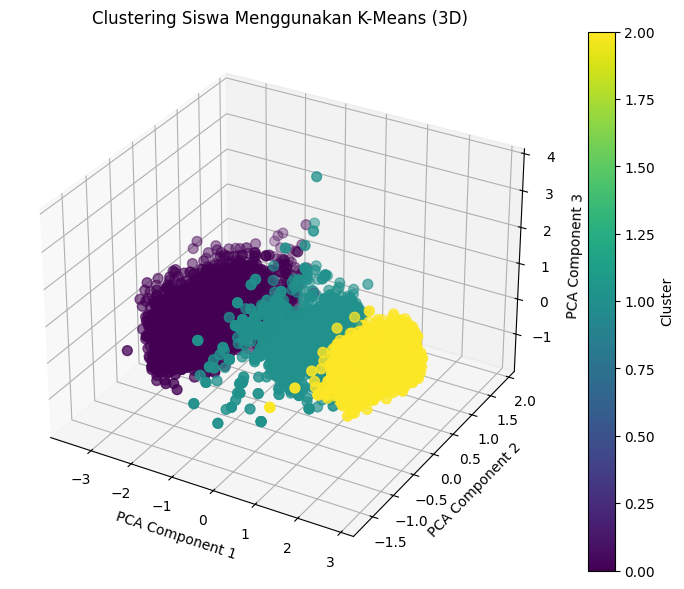

In [ ]:
# Tentukan range jumlah cluster
cluster_range = range(2, 10)  # Misalnya, coba 2 hingga 9 cluster
cv_results = {}
elbow_sse = []

print("Processing Clusters...\n")
print("Clusters | SSE               | Mean Silhouette Score")
print("-" * 50)

# Loop untuk mengevaluasi jumlah cluster
for n_clusters in cluster_range:
    cv_silhouette_scores = []
    sse = 0

    for train_index, test_index in KFold(n_splits=5, shuffle=True, random_state=42).split(features_scaled):
        X_train, X_test = features_scaled[train_index], features_scaled[test_index]

        # Melatih model K-Means
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(X_train)

        # Prediksi dan evaluasi pada test split
        test_labels = kmeans.predict(X_test)
        score = silhouette_score(X_test, test_labels)
        cv_silhouette_scores.append(score)

        # Hitung SSE (Sum of Squared Errors)
        sse += kmeans.inertia_

    # Rata-rata SSE dan Silhouette Score
    mean_silhouette_score = np.mean(cv_silhouette_scores)
    mean_sse = sse / 5  # Rata-rata SSE dari 5 fold

    # Simpan hasil untuk jumlah cluster ini
    cv_results[n_clusters] = mean_silhouette_score
    elbow_sse.append(mean_sse)

    # Tampilkan hasil debugging
    print(f"{n_clusters:^8} | {mean_sse:<16.4f} | {mean_silhouette_score:<.4f}")

# Tentukan jumlah cluster optimal berdasarkan hasil (contoh: 3 cluster)
optimal_clusters = 3
final_kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
final_labels = final_kmeans.fit_predict(features_scaled)

# Evaluasi pada seluruh dataset
final_silhouette_score = silhouette_score(features_scaled, final_labels)
print(f"Final Silhouette Score on Test Set: {final_silhouette_score}")

# Tambahkan hasil clustering ke DataFrame asli
id_fullname_df['cluster'] = final_labels

# Tambahkan hasil cluster ke dataframe utama
df['optimal_cluster'] = final_labels

# Hitung rata-rata fitur dalam setiap cluster
cluster_summary = df.groupby('optimal_cluster')[['english', 'science', 'math', 'social_science', 'art_culture', 'studytime']].mean()
print("\nDataframe dengan cluster:")
print(id_fullname_df)
print("\nRingkasan cluster:")
print(cluster_summary)

# Plot grafik Elbow Method dan Silhouette Score
plt.figure(figsize=(14, 6))

# Grafik Elbow Method
plt.subplot(1, 2, 1)
plt.plot(cluster_range, elbow_sse, marker='o', label='SSE')
plt.title('Elbow Method (SSE vs. Number of Clusters)')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Error (SSE)')
plt.xticks(cluster_range)
plt.grid(True)
plt.legend()

# Grafik Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(cluster_range, [cv_results[k] for k in cluster_range], marker='o', color='orange', label='Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(cluster_range)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Visualisasi hasil clustering dalam 3D
pca = PCA(n_components=3)
features_pca = pca.fit_transform(features_scaled)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2],
                      c=df['optimal_cluster'], cmap='viridis', s=50)
ax.set_title('Clustering Siswa Menggunakan K-Means (3D)')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
plt.colorbar(scatter, ax=ax, label='Cluster')
plt.show()

# Hasil Akhir dengan 3 cluster dan PCA 90% (Detail)

Processing Clusters...

Evaluating 2 clusters:
  Fold 1:
    SSE (Fold): 6754.4460
    Silhouette Score (Fold): 0.5776
  Fold 2:
    SSE (Fold): 6737.9704
    Silhouette Score (Fold): 0.5765
  Fold 3:
    SSE (Fold): 6738.7624
    Silhouette Score (Fold): 0.5749
  Fold 4:
    SSE (Fold): 6715.4501
    Silhouette Score (Fold): 0.5695
  Fold 5:
    SSE (Fold): 6828.5192
    Silhouette Score (Fold): 0.5849
Average SSE: 6755.0296
Average Silhouette Score: 0.5767
Clusters | SSE               | Mean Silhouette Score
--------------------------------------------------
   2     | 6755.0296        | 0.5767

Evaluating 3 clusters:
  Fold 1:
    SSE (Fold): 3245.4384
    Silhouette Score (Fold): 0.5592
  Fold 2:
    SSE (Fold): 3207.6233
    Silhouette Score (Fold): 0.5558
  Fold 3:
    SSE (Fold): 3240.4654
    Silhouette Score (Fold): 0.5623
  Fold 4:
    SSE (Fold): 3231.0965
    Silhouette Score (Fold): 0.5625
  Fold 5:
    SSE (Fold): 3260.0707
    Silhouette Score (Fold): 0.5626
Average SSE:

<Figure size 1400x600 with 0 Axes>

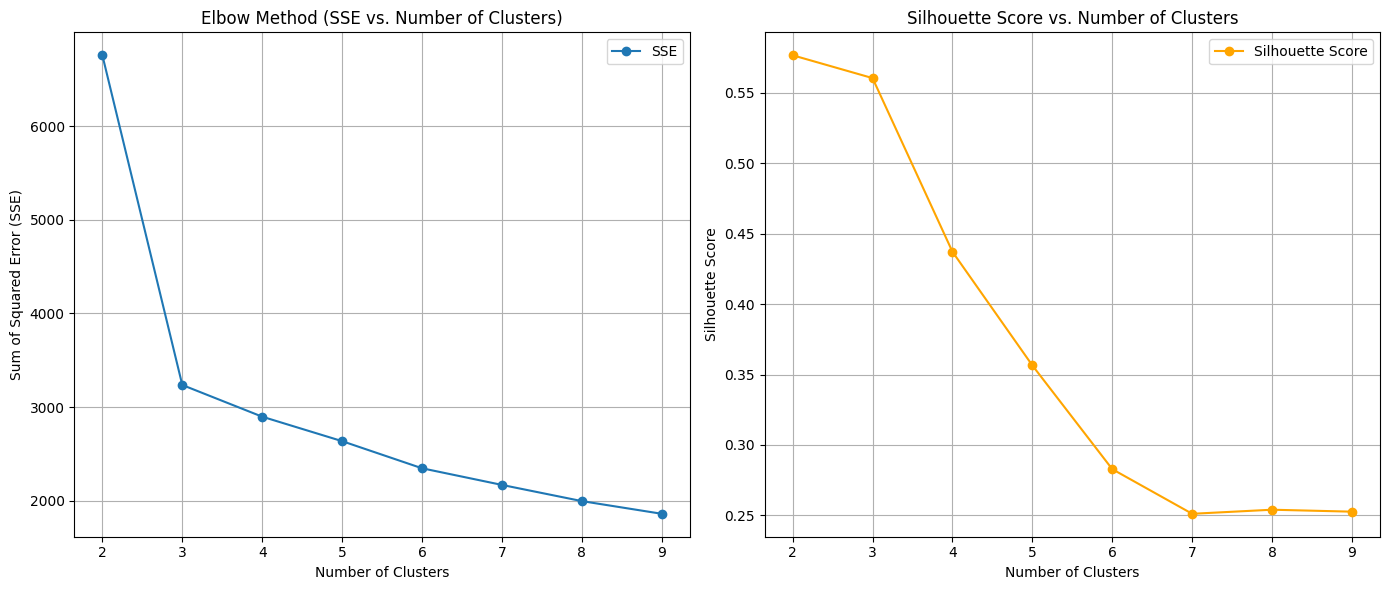

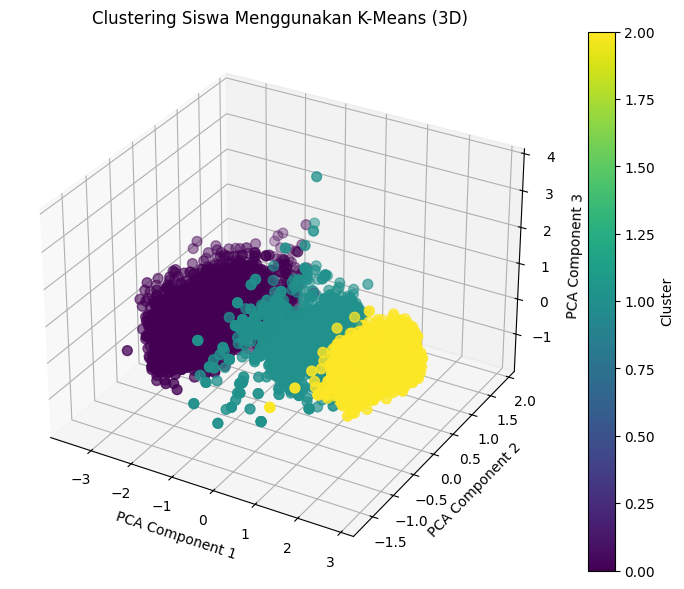

In [ ]:
# Tentukan range jumlah cluster
cluster_range = range(2, 10)  # Misalnya, coba 2 hingga 9 cluster
cv_results = {}
elbow_sse = []

print("Processing Clusters...")
# Modifikasi loop untuk debugging setiap fold
for n_clusters in cluster_range:
    cv_silhouette_scores = []
    sse = 0

    print(f"\nEvaluating {n_clusters} clusters:")
    fold_number = 1  # Untuk melacak fold ke berapa

    for train_index, test_index in KFold(n_splits=5, shuffle=True, random_state=42).split(features_scaled):
        X_train, X_test = features_scaled[train_index], features_scaled[test_index]

        # Melatih model K-Means
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(X_train)

        # Prediksi dan evaluasi pada test split
        test_labels = kmeans.predict(X_test)
        score = silhouette_score(X_test, test_labels)
        cv_silhouette_scores.append(score)

        # Hitung SSE (Sum of Squared Errors)
        fold_sse = kmeans.inertia_
        sse += fold_sse

        # Debugging setiap fold
        print(f"  Fold {fold_number}:")
        print(f"    SSE (Fold): {fold_sse:.4f}")
        print(f"    Silhouette Score (Fold): {score:.4f}")
        fold_number += 1

    # Rata-rata SSE dan Silhouette Score
    mean_silhouette_score = np.mean(cv_silhouette_scores)
    mean_sse = sse / 5  # Rata-rata SSE dari 5 fold

    # Simpan hasil untuk jumlah cluster ini
    cv_results[n_clusters] = mean_silhouette_score
    elbow_sse.append(mean_sse)

    # Debugging hasil rata-rata per cluster
    print(f"Average SSE: {mean_sse:.4f}")
    print(f"Average Silhouette Score: {mean_silhouette_score:.4f}")

    # Tampilkan hasil debugging
    print("Clusters | SSE               | Mean Silhouette Score")
    print("-" * 50)
    print(f"{n_clusters:^8} | {mean_sse:<16.4f} | {mean_silhouette_score:<.4f}")

# Melatih K-Means dengan jumlah cluster optimal (dalam contoh, 3 clusters)
optimal_clusters = 3
final_kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
final_kmeans.fit(features_scaled)

# Evaluasi pada Test Set
test_labels = final_kmeans.predict(features_scaled)
final_silhouette_score = silhouette_score(features_scaled, test_labels)
print(f"Final Silhouette Score on Test Set: {final_silhouette_score}")

# Tambahkan hasil clustering ke DataFrame asli
id_fullname_df['cluster'] = final_labels

# Tambahkan hasil cluster ke dataframe utama
df['optimal_cluster'] = final_labels

# Hitung rata-rata fitur dalam setiap cluster
cluster_summary = df.groupby('optimal_cluster')[['english', 'science', 'math', 'social_science', 'art_culture', 'studytime']].mean()
print("\nDataframe dengan cluster:")
print(id_fullname_df)
print("\nRingkasan cluster:")
print(cluster_summary)

# Plot grafik Elbow Method dan Silhouette Score
plt.figure(figsize=(14, 6))

# Plot grafik Elbow Method dan Silhouette Score
plt.figure(figsize=(14, 6))

# Grafik Elbow Method
plt.subplot(1, 2, 1)
plt.plot(cluster_range, elbow_sse, marker='o', label='SSE')
plt.title('Elbow Method (SSE vs. Number of Clusters)')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Error (SSE)')
plt.xticks(cluster_range)
plt.grid(True)
plt.legend()

# Grafik Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(cluster_range, [cv_results[k] for k in cluster_range], marker='o', color='orange', label='Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(cluster_range)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Visualisasi hasil clustering dalam 3D
pca = PCA(n_components=3)
features_pca = pca.fit_transform(features_scaled)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2],
                      c=df['optimal_cluster'], cmap='viridis', s=50)
ax.set_title('Clustering Siswa Menggunakan K-Means (3D)')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
plt.colorbar(scatter, ax=ax, label='Cluster')
plt.show()

# Post Clustering Analysis

## Boxplot Feature per Cluster

### Academic Performance (Fitur yang digunakan untuk clustering)

In [ ]:
import plotly.express as px

original_df = pd.read_csv(url)
# Buat DataFrame dengan fitur akademik dan cluster
academic_data = original_df[['cluster'] + academic_cols].melt(id_vars='cluster',
                                                               var_name='Subject',
                                                               value_name='Score')

# Plot Boxplot
fig_academic_box = px.box(academic_data, x='Subject', y='Score', color='cluster',
                          title='Academic Performance Distribution by Cluster')
fig_academic_box.update_layout(
    xaxis_title='Subjects',
    yaxis_title='Scores',
    height=600
)
fig_academic_box.show()


### Supporting Fitur

In [ ]:
# Filter hanya fitur numerikal dari support_cols
numerical_support_cols = [col for col in support_cols if original_df[col].dtype in ['int64', 'float64']]

# Buat DataFrame dengan fitur pendukung numerikal dan cluster
support_data_numerical = original_df[['cluster'] + numerical_support_cols].melt(id_vars='cluster',
                                                                                var_name='Factor',
                                                                                value_name='Value')

# Plot Boxplot
fig_support_box = px.box(support_data_numerical, x='Factor', y='Value', color='cluster',
                         title='Distribution of Supporting Factors by Cluster')
fig_support_box.update_layout(
    xaxis_tickangle=-45,
    xaxis_title='Factors',
    yaxis_title='Value',
    height=600
)
fig_support_box.show()



### Fitur Lainnya

In [ ]:
# Contoh konversi kategorikal ke numerik
categorical_support_cols = [col for col in support_cols if original_df[col].dtype == 'object']

for col in categorical_support_cols:
    original_df[col] = original_df[col].astype('category').cat.codes

# Buat DataFrame dengan faktor kategorikal yang telah dikonversi
support_data_categorical = original_df[['cluster'] + categorical_support_cols].melt(id_vars='cluster',
                                                                                    var_name='Factor',
                                                                                    value_name='Value')

# Plot Boxplot
fig_categorical_box = px.box(support_data_categorical, x='Factor', y='Value', color='cluster',
                             title='Categorical Factors (Encoded) Distribution by Cluster')
fig_categorical_box.update_layout(
    xaxis_tickangle=-45,
    xaxis_title='Factors',
    yaxis_title='Encoded Values',
    height=600
)
fig_categorical_box.show()


## Analisis Lebih lanjut

In [ ]:

original_df['cluster'] = df['optimal_cluster']
# Function untuk mendapatkan statistik per cluster
def get_cluster_statistics(df):
    cluster_stats = []

    for cluster in df['cluster'].unique():
        cluster_data = df[df['cluster'] == cluster]

        # Hitung rata-rata nilai akademik per cluster
        academic_means = {
            'cluster': f'Cluster {cluster}',
            'english': cluster_data['english'].mean(),
            'math': cluster_data['math'].mean(),
            'science': cluster_data['science'].mean(),
            'social_science': cluster_data['social_science'].mean(),
            'art_culture': cluster_data['art_culture'].mean()
        }
        cluster_stats.append(academic_means)

    return cluster_stats

# Function untuk mendapatkan statistik faktor pendukung
def get_support_factors(df):
    support_metrics = []

    categorical_cols = ['internet_access', 'tutoring', 'extra_curricular_activities', 'parental_involvement']

    for factor in categorical_cols:
        factor_stats = {'name': factor}
        for cluster in df['cluster'].unique():
            cluster_data = df[df['cluster'] == cluster]
            # Hitung persentase 'yes' atau nilai positif
            positive_pct = (cluster_data[factor].value_counts(normalize=True).get('yes', 0) * 100)
            factor_stats[f'cluster{cluster}'] = positive_pct
        support_metrics.append(factor_stats)

    return support_metrics

# Hitung statistik cluster
cluster_info = original_df['cluster'].value_counts().reset_index()
cluster_info.columns = ['cluster', 'count']
cluster_info = cluster_info.sort_values('cluster')

# Dapatkan statistik akademik
academic_stats = get_cluster_statistics(original_df)

# Dapatkan statistik faktor pendukung
support_stats = get_support_factors(original_df)

# Konversi ke format JSON untuk React
dashboard_data = {
    'clusterInfo': cluster_info.to_dict('records'),
    'academicMetrics': academic_stats,
    'demographicData': support_stats
}

print("Dashboard Data:")
print("\nCluster Distribution:")
print(dashboard_data['clusterInfo'])
print("\nAcademic Metrics:")
print(dashboard_data['academicMetrics'])
print("\nDemographic Data:")
print(dashboard_data['demographicData'])

Dashboard Data:

Cluster Distribution:
[{'cluster': 0, 'count': 2638}, {'cluster': 1, 'count': 3201}, {'cluster': 2, 'count': 2773}]

Academic Metrics:
[{'cluster': 'Cluster 2', 'english': 89.76307248467364, 'math': 89.71294626758024, 'science': 89.46916696718355, 'social_science': 89.67904796249549, 'art_culture': 90.08727010457987}, {'cluster': 'Cluster 1', 'english': 74.66229303342705, 'math': 73.68541080912215, 'science': 74.39206497969384, 'social_science': 75.60481099656357, 'art_culture': 76.4036238675414}, {'cluster': 'Cluster 0', 'english': 55.35481425322214, 'math': 54.39802880970432, 'science': 55.709628506444275, 'social_science': 57.090978013646705, 'art_culture': 61.47270659590599}]

Demographic Data:
[{'name': 'internet_access', 'cluster2': 0, 'cluster1': 0, 'cluster0': 0}, {'name': 'tutoring', 'cluster2': 0, 'cluster1': 0, 'cluster0': 0}, {'name': 'extra_curricular_activities', 'cluster2': 0, 'cluster1': 0, 'cluster0': 0}, {'name': 'parental_involvement', 'cluster2': 0,

## Visualisasi Distribusi Siswa Antar Cluster dan Korelasi dengan Fitur lainnya

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Baca dataset
url = '/root/.cache/kagglehub/datasets/satayjit/student-performance-bd/versions/3/bd_students_per_v2.csv'
original_df = pd.read_csv(url)

# Gabungkan dengan hasil clustering
original_df['cluster'] = df['optimal_cluster']  # df adalah DataFrame yang sudah memiliki hasil clustering

# 1. Visualisasi Distribusi Cluster (Pie Chart)
cluster_dist = original_df['cluster'].value_counts().reset_index()
cluster_dist.columns = ['Cluster', 'Count']

fig_pie = px.pie(cluster_dist, values='Count', names='Cluster',
                 title='Distribution of Students Across Clusters',
                 color_discrete_sequence=px.colors.qualitative.Set3)
fig_pie.show()

# 2. Visualisasi Performa Akademik per Cluster
academic_cols = ['english', 'math', 'science', 'social_science', 'art_culture']
cluster_means = original_df.groupby('cluster')[academic_cols].mean().reset_index()

fig_academic = go.Figure()
for subject in academic_cols:
    fig_academic.add_trace(go.Bar(
        name=subject.capitalize(),
        x=cluster_means['cluster'],
        y=cluster_means[subject],
        text=cluster_means[subject].round(1),
        textposition='auto',
    ))

fig_academic.update_layout(
    title='Academic Performance by Cluster',
    xaxis_title='Cluster',
    yaxis_title='Average Score',
    barmode='group',
    showlegend=True
)
fig_academic.show()

# 3. Visualisasi Faktor Pendukung
# Perbaikan: definisikan support_cols sebagai list string
support_cols = ["age", "gender", "location", "family_size", "mother_education",
                "father_education", "mother_job", "father_job", "guardian",
                "parental_involvement", "internet_access", "studytime", "tutoring",
                "school_type", "attendance", "extra_curricular_activities", "stu_group"]

# Fungsi untuk menghitung persentase kategorikal
def calculate_category_percentage(df, col):
    # Jika kolom numerik, kembalikan mean
    if df[col].dtype in ['int64', 'float64']:
        return df[col].mean()
    # Jika kolom kategorikal, hitung persentase modus
    else:
        mode_category = df[col].mode()[0]
        return (df[col] == mode_category).mean() * 100

support_data = []
for cluster in sorted(original_df['cluster'].unique()):
    cluster_data = original_df[original_df['cluster'] == cluster]
    for col in support_cols:
        support_data.append({
            'Cluster': f'Cluster {cluster}',
            'Factor': col,
            'Percentage': calculate_category_percentage(cluster_data, col)
        })

support_df = pd.DataFrame(support_data)

fig_support = px.bar(support_df, x='Factor', y='Percentage', color='Cluster',
                    title='Student Characteristics by Cluster',
                    barmode='group')
# Rotate x-axis labels for better readability
fig_support.update_layout(
    xaxis_tickangle=-45,
    height=600  # Make the plot taller
)
fig_support.show()


## Detail Statistik

In [ ]:
# 4. Detail Statistik per Cluster
for cluster in sorted(original_df['cluster'].unique()):
    cluster_data = original_df[original_df['cluster'] == cluster]
    print(f"\nCluster {cluster} Statistics:")
    print("-" * 50)
    print(f"Number of students: {len(cluster_data)}")
    print("\nAcademic Performance:")
    print(cluster_data[academic_cols].mean().round(2))
    print("\nKey Characteristics:")
    for col in support_cols:
        if cluster_data[col].dtype in ['int64', 'float64']:
            mean_val = cluster_data[col].mean()
            print(f"{col} (mean): {mean_val:.1f}")
        else:
            mode_val = cluster_data[col].mode()[0]
            pct = (cluster_data[col] == mode_val).mean() * 100
            print(f"{col} (most common): {mode_val} ({pct:.1f}%)")
    print("-" * 50)



Cluster 0 Statistics:
--------------------------------------------------
Number of students: 2638

Academic Performance:
english           55.35
math              54.40
science           55.71
social_science    57.09
art_culture       61.47
dtype: float64

Key Characteristics:
age (mean): 16.6
gender (most common): Male (50.8%)
location (most common): Urban (33.5%)
family_size (mean): 4.5
mother_education (most common): SSC (15.7%)
father_education (most common): SSC (15.4%)
mother_job (most common): No (51.2%)
father_job (most common): Yes (53.9%)
guardian (most common): Father (34.3%)
parental_involvement (most common): Yes (50.9%)
internet_access (most common): Yes (50.9%)
studytime (mean): 2.1
tutoring (most common): No (51.4%)
school_type (most common): Semi_Govt (45.1%)
attendance (mean): 66.7
extra_curricular_activities (most common): Yes (50.8%)
stu_group (most common): Arts (97.8%)
--------------------------------------------------

Cluster 1 Statistics:
---------------------

## Radar Chart

In [ ]:
# 5. Visualisasi Radar Chart untuk membandingkan karakteristik cluster
fig_radar = go.Figure()

for cluster in sorted(original_df['cluster'].unique()):
    cluster_data = original_df[original_df['cluster'] == cluster]

    # Hitung rata-rata untuk setiap metrik
    metrics = {}
    for col in academic_cols:
        metrics[col] = cluster_data[col].mean()

    fig_radar.add_trace(go.Scatterpolar(
        r=[metrics[col] for col in academic_cols],
        theta=academic_cols,
        name=f'Cluster {cluster}'
    ))

fig_radar.update_layout(
    polar=dict(radialaxis=dict(visible=True, range=[0, 100])),
    showlegend=True,
    title='Academic Performance Comparison Across Clusters'
)
fig_radar.show()